# Resampling Hypothesis Tests for K Samples

In statistical hypothesis testing, a k-sample test is performed on the data of k-random samples. The purpose is to determine whether the population difference is statistically significant.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

from statsmodels.distributions.empirical_distribution import ECDF

## Bootstrap Method for two Independent Samples

The bootstrap method idea is simple: "If there is no difference between two treatments, a particular score is just as likely to end up in one group as in the other."

Let us generate some data.

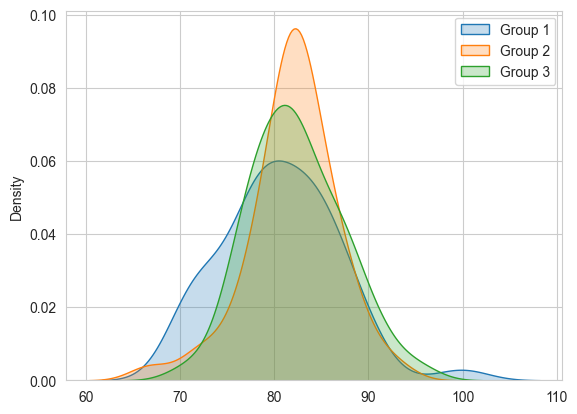

In [2]:
# Set the random number generator to a fixed sequence.
np.random.seed(50) 
g1_grades = np.random.normal(80, 6, size=50)
g2_grades = np.random.normal(82, 4, size=48)
g3_grades = np.random.normal(83, 5, size=52)

sns.kdeplot(g1_grades, fill = True, label="Group 1")
sns.kdeplot(g2_grades, fill = True, label="Group 2")
sns.kdeplot(g3_grades, fill = True, label="Group 3")
plt.legend();

In [3]:
print('Group 1 mean = %.2f' % g1_grades.mean())
print('Group 2 mean = %.2f' % g2_grades.mean())
print('Group 3 mean = %.2f' % g3_grades.mean())

Group 1 mean = 80.56
Group 2 mean = 81.92
Group 3 mean = 82.27


Let us transform the original samples into others that share their means.

In [4]:
# Getting the overall mean of the three independent samples
overall_mean_grades = np.concatenate((g1_grades, g2_grades, g3_grades)).mean()
print('Mean of combined sample = %.2f' % overall_mean_grades)

Mean of combined sample = 81.59


In [5]:
# Creating the new variables classC_shifted and classD_shifted that share the mean
g1_grades_shifted = g1_grades - g1_grades.mean() + overall_mean_grades
g2_grades_shifted = g2_grades - g2_grades.mean() + overall_mean_grades
g3_grades_shifted = g3_grades - g3_grades.mean() + overall_mean_grades

print('Mean of shifted g1_grades = %.2f' % g1_grades_shifted.mean())
print('Mean of shifted g2_grades = %.2f' % g2_grades_shifted.mean())
print('Mean of shifted g3_grades = %.2f' % g3_grades_shifted.mean())

Mean of shifted g1_grades = 81.59
Mean of shifted g2_grades = 81.59
Mean of shifted g3_grades = 81.59


`generate_samples` is the function for generating samples WITH replacement.

In [6]:
def generate_samples(sample_data, num_samples=10000):
    '''
    It generates num_samples samples using sample_data with the bootstrap method 
    and returns a DataFrame where each column is a sample.    
    '''
    sample_size = len(sample_data)
    col = ['S'+str(k) for k in range(num_samples)]
    samp = np.random.choice(sample_data, replace=True, size=sample_size*num_samples)
    df = pd.DataFrame(samp.reshape(sample_size, num_samples), columns=col)
    return(df)  

In [7]:
df_1 = generate_samples(g1_grades_shifted, num_samples=10000)
df_2 = generate_samples(g1_grades_shifted, num_samples=10000)
df_3 = generate_samples(g1_grades_shifted, num_samples=10000)

We will use the following statistic: 
- square root root of the weighted sum of squared deviations between each mean and the overall mean

In [8]:
# Computing the statistic
n1 = len(g1_grades)
n2 = len(g2_grades)
n3 = len(g3_grades)
tot = n1 + n2 + n3
test_stat_bootI = np.sqrt((n1/tot) * (g1_grades.mean() - overall_mean_grades)**2 + 
                          (n2/tot) * (g2_grades.mean() - overall_mean_grades)**2 + 
                          (n3/tot) * (g3_grades.mean() - overall_mean_grades)**2)
print('Test statistic = %.2f' % test_stat_bootI)                  

Test statistic = 0.74


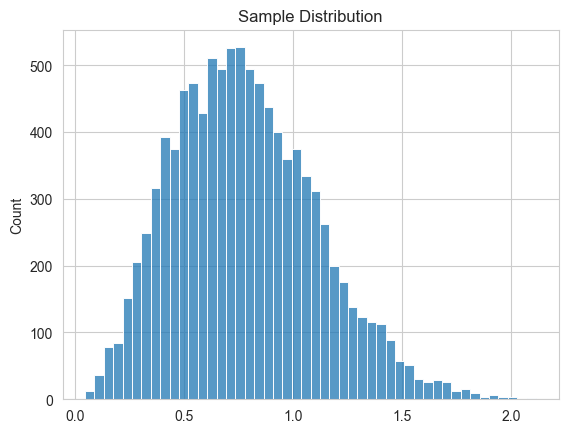

In [9]:
# Computing and plotting the sample distribution of the statistic
sample_distribution_bootI = np.sqrt((n1/tot) * (df_1.mean() - overall_mean_grades)**2 + 
                                    (n2/tot) * (df_2.mean() - overall_mean_grades)**2 + 
                                    (n3/tot) * (df_3.mean() - overall_mean_grades)**2)  
sns.histplot(x=sample_distribution_bootI).set(title='Sample Distribution');      

In [10]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):    
    '''
    It returns the p-value.
    sample_distribution:    the sample distribution
    obs_value:              the observed value     
    alternative:            'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2*min(ecdf(obs_value), 1 - ecdf(obs_value))        
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [11]:
def graph_hyp_test(sample_value, sample_distribution, alpha=0.05, alternative='two-sided'):
    '''
    It computes and graph the two-samples hypothesis test.
    sample_value:           observed value calculated from the sample
    sample_distribution:    sample distribution calculated from the sample
    alpha:                  significance level
    alternative:            'two-sided', 'smaller', and 'larger'
    '''
    print('--- Hypothesis Test ---')
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='skyblue', fill=True).set_title('Sample Distribution')  
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)       
    # get the p-value
    p_val = get_p_value(sample_distribution, sample_value, alternative)
    # plotting the two critical regions
    if alternative=='two-sided':        
        cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)         # left critical value    
        cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)     # right critical value    
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    # plotting the left critical region
    elif alternative=='smaller':        
        cv1 = np.round(np.percentile(sample_distribution, alpha*100),2)             # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # plotting the right critical region
    else:                               
        cv2 = np.round(np.percentile(sample_distribution, 100-alpha*100),2)         # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # printing the statistic and the p-value    
    print('Observed Value = %.2f\tp-value = %.4f' %(sample_value, p_val))  

--- Hypothesis Test ---


Observed Value = 0.74	p-value = 0.9764


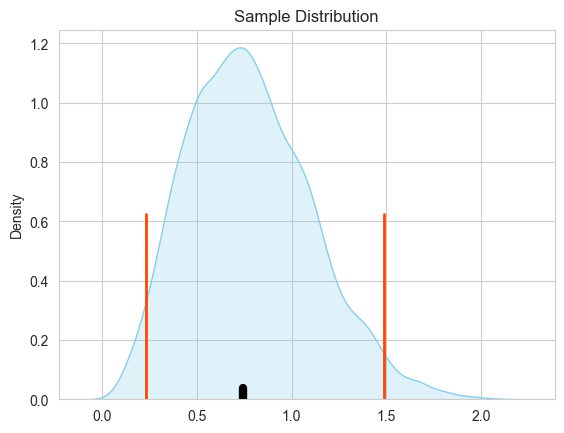

In [12]:
graph_hyp_test(test_stat_bootI, sample_distribution_bootI)

In [13]:
# Creating another variable with g4_grades
g4_grades = np.random.normal(60, 5, size=44)

In [14]:
overall_mean_grades4 = np.concatenate((g1_grades, g2_grades, g3_grades, g4_grades)).mean()

g4_grades_shifted = g4_grades - g4_grades.mean() + overall_mean_grades4

df_4 = generate_samples(g4_grades_shifted, num_samples=10000)

In [15]:
# Computing the statistic
n4 = len(g4_grades)
tot4 = n1 + n2 + n3 + n4
test_stat_bootI4 = np.sqrt((n1/tot4) * (g1_grades.mean() - overall_mean_grades4)**2 + 
                           (n2/tot4) * (g2_grades.mean() - overall_mean_grades4)**2 + 
                           (n3/tot4) * (g3_grades.mean() - overall_mean_grades4)**2 +
                           (n4/tot4) * (g4_grades.mean() - overall_mean_grades4)**2)
print('Test statistic = %.2f' % test_stat_bootI4)   

Test statistic = 9.25


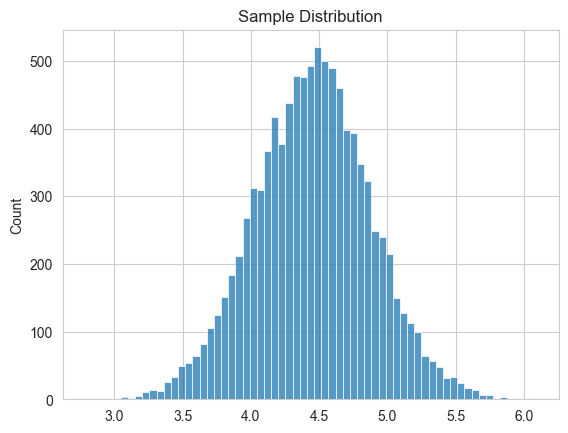

In [16]:
# Computing and plotting the sample distribution of the statistic
sample_distribution_bootI4 = np.sqrt((n1/tot4) * (df_1.mean() - overall_mean_grades4)**2 +
                                     (n2/tot4) * (df_2.mean() - overall_mean_grades4)**2 +
                                     (n3/tot4) * (df_3.mean() - overall_mean_grades4)**2 + 
                                     (n4/tot4) * (df_4.mean() - overall_mean_grades4)**2)
sns.histplot(x=sample_distribution_bootI4).set(title='Sample Distribution');      

--- Hypothesis Test ---
Observed Value = 9.25	p-value = 0.0000


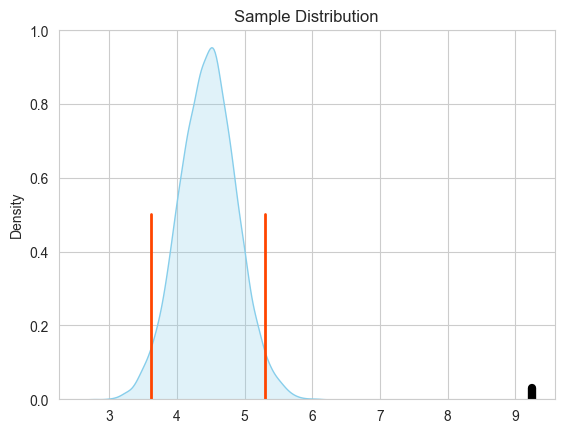

In [17]:
graph_hyp_test(test_stat_bootI4, sample_distribution_bootI4)

## Bootstrap method for k-related samples

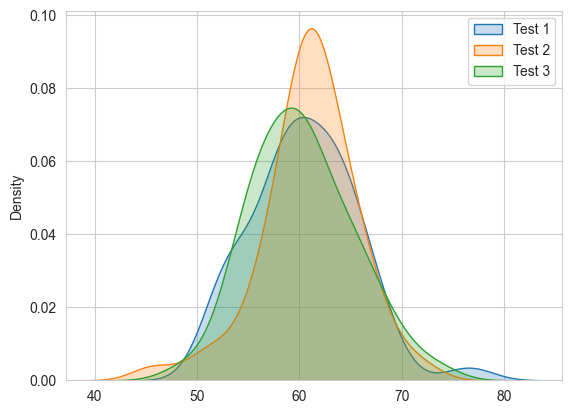

In [18]:
# Generating data
np.random.seed(50) 
test1 = np.random.normal(60, 5, size = 50)
test2 = np.random.normal(61, 4, size = 50)
test3 = np.random.normal(61, 5, size = 50)

sns.kdeplot(test1, fill = True, label = "Test 1")
sns.kdeplot(test2, fill = True, label = "Test 2")
sns.kdeplot(test3, fill = True, label = "Test 3")
plt.legend();

We will use the mean of the absolute value of the differences of all pairs of samples as statistic.

In [19]:
# Computing the statistic
test_stat_bootR = (np.abs(test1.mean() - test2.mean()) + 
                   np.abs(test1.mean() - test3.mean()) + 
                   np.abs(test2.mean() - test3.mean())) / 3
print('Test statistic = %.2f' % test_stat_bootR)    

Test statistic = 0.49


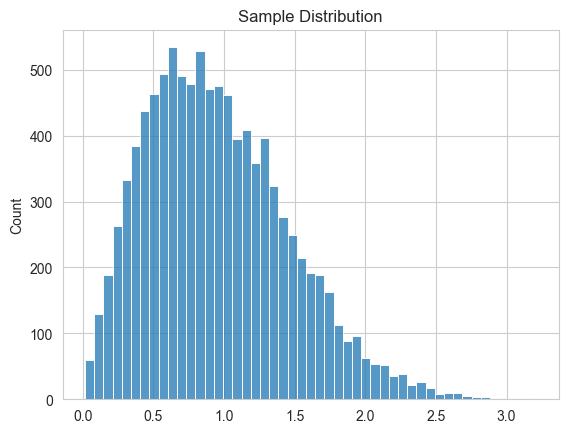

In [20]:
# Computing the sample distribution of the statistic
sample_distribution_bootR = (np.abs(df_1.mean() - df_2.mean()).values + 
                             np.abs(df_1.mean() - df_3.mean()).values + 
                             np.abs(df_2.mean() - df_3.mean()).values) / 3
sns.histplot(x=sample_distribution_bootR).set(title='Sample Distribution');

--- Hypothesis Test ---
Observed Value = 0.49	p-value = 0.3844


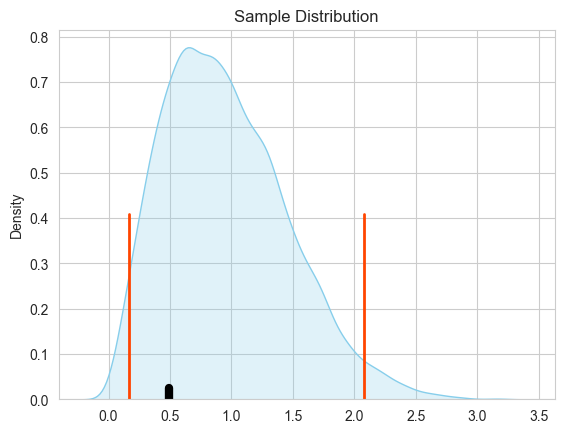

In [21]:
graph_hyp_test(test_stat_bootR, sample_distribution_bootR)

In [22]:
# Let's generate more data
np.random.seed(50) 
test4 = np.random.normal(70, 4, size = 50)

In [23]:
# Computing the statistic
test_stat_bootR4 = (np.abs(test1.mean() - test2.mean()) + 
                    np.abs(test1.mean() - test3.mean()) + 
                    np.abs(test1.mean() - test4.mean()) +
                    np.abs(test2.mean() - test3.mean()) +
                    np.abs(test2.mean() - test4.mean()) +
                    np.abs(test3.mean() - test4.mean())) / 6                           
print('Test statistic = %.2f' % test_stat_bootR4)    

Test statistic = 5.16


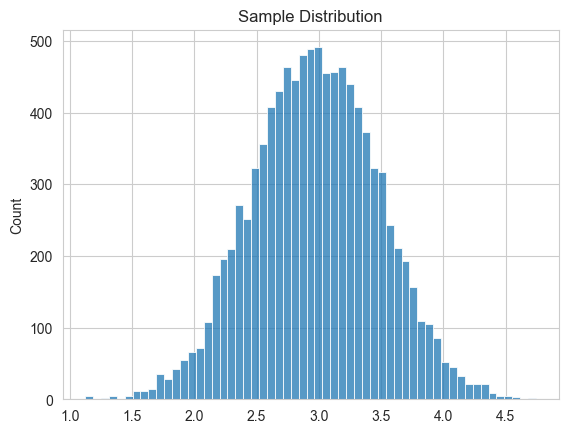

In [24]:
# Computing the sample distribution of the statistic
sample_distribution_bootR4 = (np.abs(df_1.mean() - df_2.mean()).values + 
                              np.abs(df_1.mean() - df_3.mean()).values + 
                              np.abs(df_1.mean() - df_4.mean()).values + 
                              np.abs(df_2.mean() - df_3.mean()).values + 
                              np.abs(df_2.mean() - df_4.mean()).values + 
                              np.abs(df_3.mean() - df_4.mean()).values) / 6
sns.histplot(x=sample_distribution_bootR4).set(title='Sample Distribution');

--- Hypothesis Test ---
Observed Value = 5.16	p-value = 0.0000


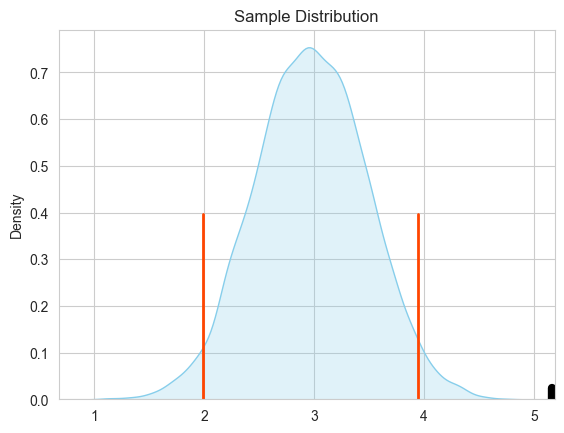

In [25]:
graph_hyp_test(test_stat_bootR4, sample_distribution_bootR4)

## Permutation Method for two Independent Samples

Let us use a permutation test to determine whether the k means are equal or not.

The method is very similar to the bootstrap, but a fundamental difference is that the bootstrap resamples with replacement and the permutation test does not. 

In [26]:
# Computing the statistic
test_stat_permI = np.sqrt((n1/tot) * (g1_grades.mean() - overall_mean_grades)**2 + 
                          (n2/tot) * (g2_grades.mean() - overall_mean_grades)**2 + 
                          (n3/tot) * (g3_grades.mean() - overall_mean_grades)**2)
print('Test statistic = %.2f' % test_stat_permI)   

Test statistic = 0.74


In [27]:
def shuffle_k_samples(*samples, num_samples=10000):
    '''
    It returns k DataFrames, where each column is a permutation (sampling without replacement)
    '''    
    pool = np.concatenate([*samples])      
    # Creating a DataFrame with one column
    df = pd.DataFrame(pool)
    # Replicating the column num_samples times
    df = (pd.concat([df]*num_samples, axis=1, ignore_index=True)).rename(lambda c: 'S'+str(c), axis=1)    
    # Shuffling the data
    df = df.apply(np.random.permutation)    
    # Creating k new DataFrames
    df_list = []
    for i in range(len(samples)):
        df_list.append(df[df.index < len(samples[i])])
        df = df[df.index >= len(samples[i])].reset_index(drop=True)            
    return df_list

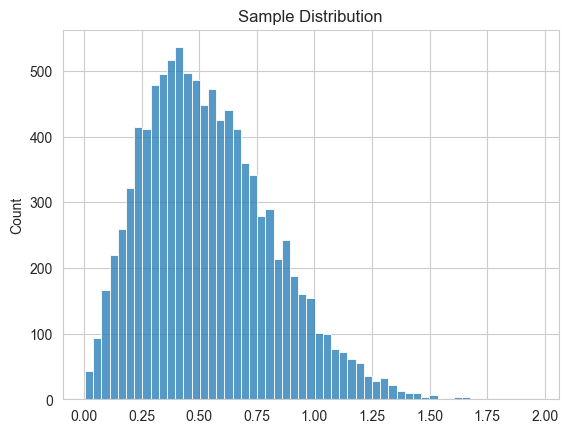

In [28]:
# Computing and plotting the sample distribution of the statistic
df_p1, df_p2, df_p3 = shuffle_k_samples(g1_grades, g2_grades, g3_grades)
sample_distribution_permI = np.sqrt((n1/tot) * (df_p1.mean() - overall_mean_grades)**2 +
                                   (n2/tot) * (df_p2.mean() - overall_mean_grades)**2 +
                                   (n3/tot) * (df_p3.mean() - overall_mean_grades)**2)    
sns.histplot(x=sample_distribution_permI).set(title='Sample Distribution');   

--- Hypothesis Test ---
Observed Value = 0.74	p-value = 0.4524


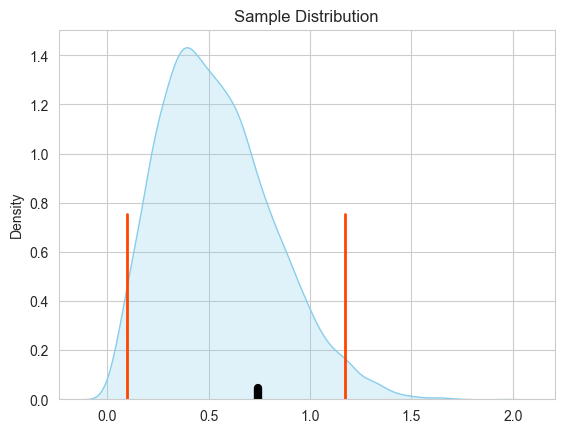

In [29]:
graph_hyp_test(test_stat_permI, sample_distribution_permI)

Including g4_grades in the analysis.

In [30]:
# Computing the statistic
test_stat_permI4 = np.sqrt((n1/tot4) * (g1_grades.mean() - overall_mean_grades4)**2 + 
                           (n2/tot4) * (g2_grades.mean() - overall_mean_grades4)**2 + 
                           (n3/tot4) * (g3_grades.mean() - overall_mean_grades4)**2 +
                           (n4/tot4) * (g4_grades.mean() - overall_mean_grades4)**2
                           )
print('Test statistic = %.2f' % test_stat_permI4)  

Test statistic = 9.25


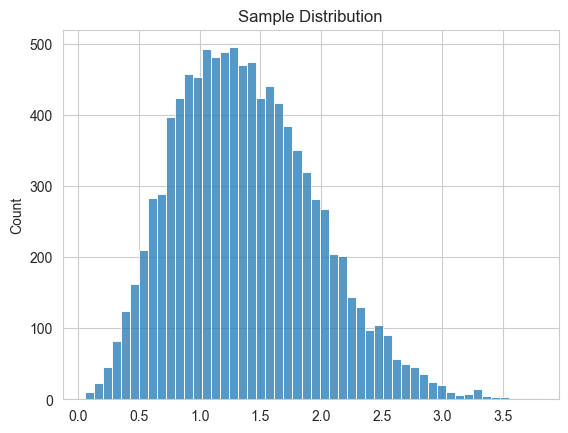

In [31]:
# Computing and plotting the sample distribution of the statistic
df_p1, df_p2, df_p3, df_p4 = shuffle_k_samples(g1_grades, g2_grades, g3_grades, g4_grades)
sample_distribution_permI4 = np.sqrt((n1/tot) * (df_p1.mean() - overall_mean_grades4)**2 +
                                     (n2/tot) * (df_p2.mean() - overall_mean_grades4)**2 +
                                     (n3/tot) * (df_p3.mean() - overall_mean_grades4)**2 +
                                     (n4/tot) * (df_p4.mean() - overall_mean_grades4)**2)    
sns.histplot(x=sample_distribution_permI4).set(title='Sample Distribution');   

--- Hypothesis Test ---
Observed Value = 9.25	p-value = 0.0000


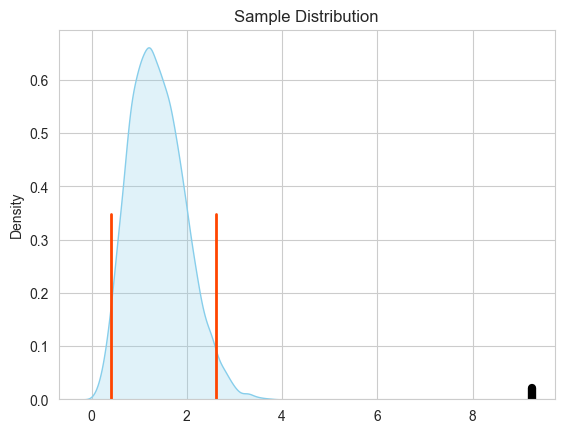

In [32]:
graph_hyp_test(test_stat_permI4, sample_distribution_permI4)

##  Permutation Test for two Paired Samples Hypothesis Test

In [33]:
# Computing the statistic
test_stat_permR = (np.abs(test1.mean() - test2.mean()) + 
                   np.abs(test1.mean() - test3.mean()) + 
                   np.abs(test2.mean() - test3.mean())) / 3
print('Test statistic = %.2f' % test_stat_permR)   

Test statistic = 0.49


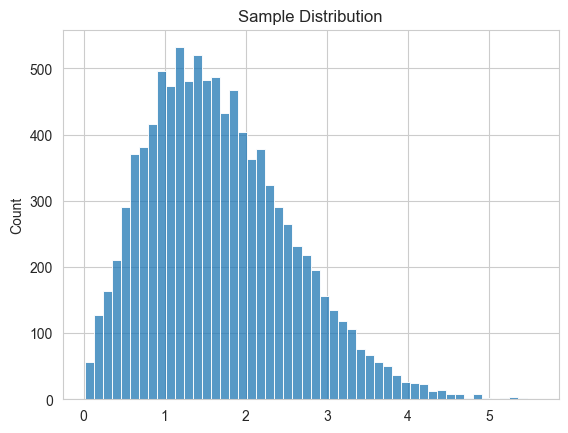

In [34]:
# Computing the sample distribution of the statistic
sample_distribution_permR = (np.abs(df_p1.mean() - df_p2.mean()).values + 
                             np.abs(df_p1.mean() - df_p3.mean()).values + 
                             np.abs(df_p2.mean() - df_p3.mean()).values) / 3
sns.histplot(x=sample_distribution_permR).set(title='Sample Distribution');

--- Hypothesis Test ---
Observed Value = 0.49	p-value = 0.1272


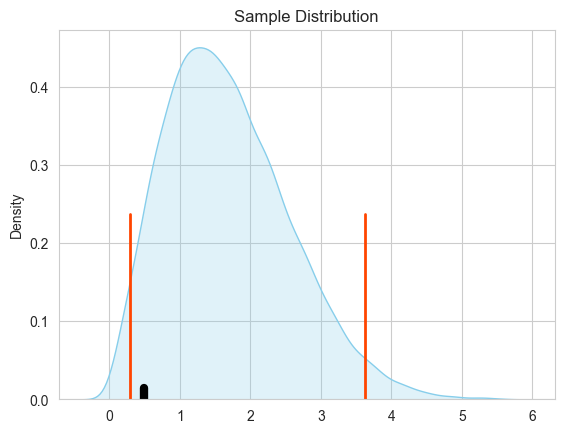

In [35]:
graph_hyp_test(test_stat_permR, sample_distribution_permR)

Including test4 in the analysis

In [36]:
# Computing the statistic
test_stat_permR4 = (np.abs(test1.mean() - test2.mean()) + 
                    np.abs(test1.mean() - test3.mean()) + 
                    np.abs(test1.mean() - test4.mean()) +
                    np.abs(test2.mean() - test3.mean()) +
                    np.abs(test2.mean() - test4.mean()) +
                    np.abs(test3.mean() - test4.mean())) / 6                           
print('Test statistic = %.2f' % test_stat_permR4)  

Test statistic = 5.16


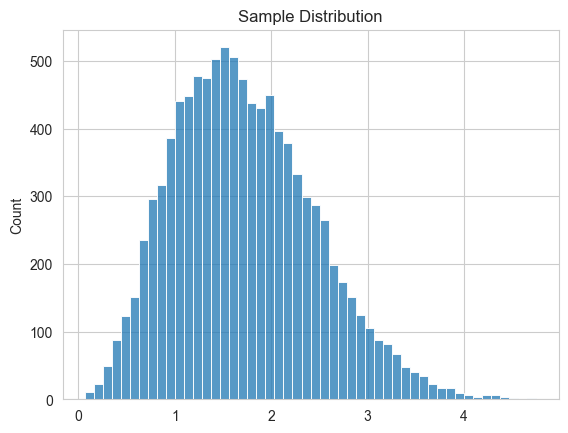

In [37]:
# Computing the sample distribution of the statistic
sample_distribution_permR4 = (np.abs(df_p1.mean() - df_p2.mean()).values + 
                              np.abs(df_p1.mean() - df_p3.mean()).values + 
                              np.abs(df_p1.mean() - df_p4.mean()).values + 
                              np.abs(df_p2.mean() - df_p3.mean()).values + 
                              np.abs(df_p2.mean() - df_p4.mean()).values + 
                              np.abs(df_p3.mean() - df_p4.mean()).values) / 6
sns.histplot(x=sample_distribution_permR4).set(title='Sample Distribution');

--- Hypothesis Test ---
Observed Value = 5.16	p-value = 0.0000


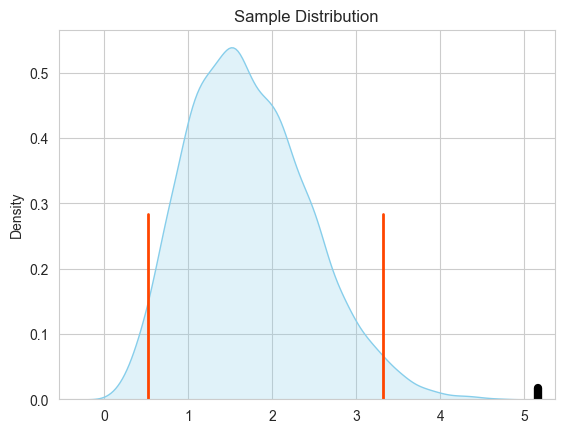

In [38]:
graph_hyp_test(test_stat_permR4, sample_distribution_permR4)

## References

- Dekking, F.M. et.al. (2005) A Modern Introduction to Probability and Statistics, USA: Springer